In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [2]:
image_path = '/kaggle/input/flickr30k/flickr30k_images'

In [3]:
data = pd.read_csv("/kaggle/input/flickr30k/captions.txt")
data.head()

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,Two young White males are outside near many b...
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .


In [4]:
data = data[['image_name', 'comment']]

In [5]:
# Rename the columns
data.rename(columns={'image_name': 'image', 'comment': 'caption'}, inplace=True)

# Now 'data' DataFrame will have columns 'image' and 'caption'
data

,image,caption
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,Two young White males are outside near many b...
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .
...,...,...
158910,998845445.jpg,A man in shorts and a Hawaiian shirt leans ove...
158911,998845445.jpg,A young man hanging over the side of a boat w...
158912,998845445.jpg,A man is leaning off of the side of a blue and...
158913,998845445.jpg,A man riding a small boat in a harbor with fo...


# **Visualization**
- Images and their corresponding captions

In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df, img_size=224):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 30))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/kaggle/input/flickr30k/flickr30k_images/{temp_df.image[i]}", img_size)
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

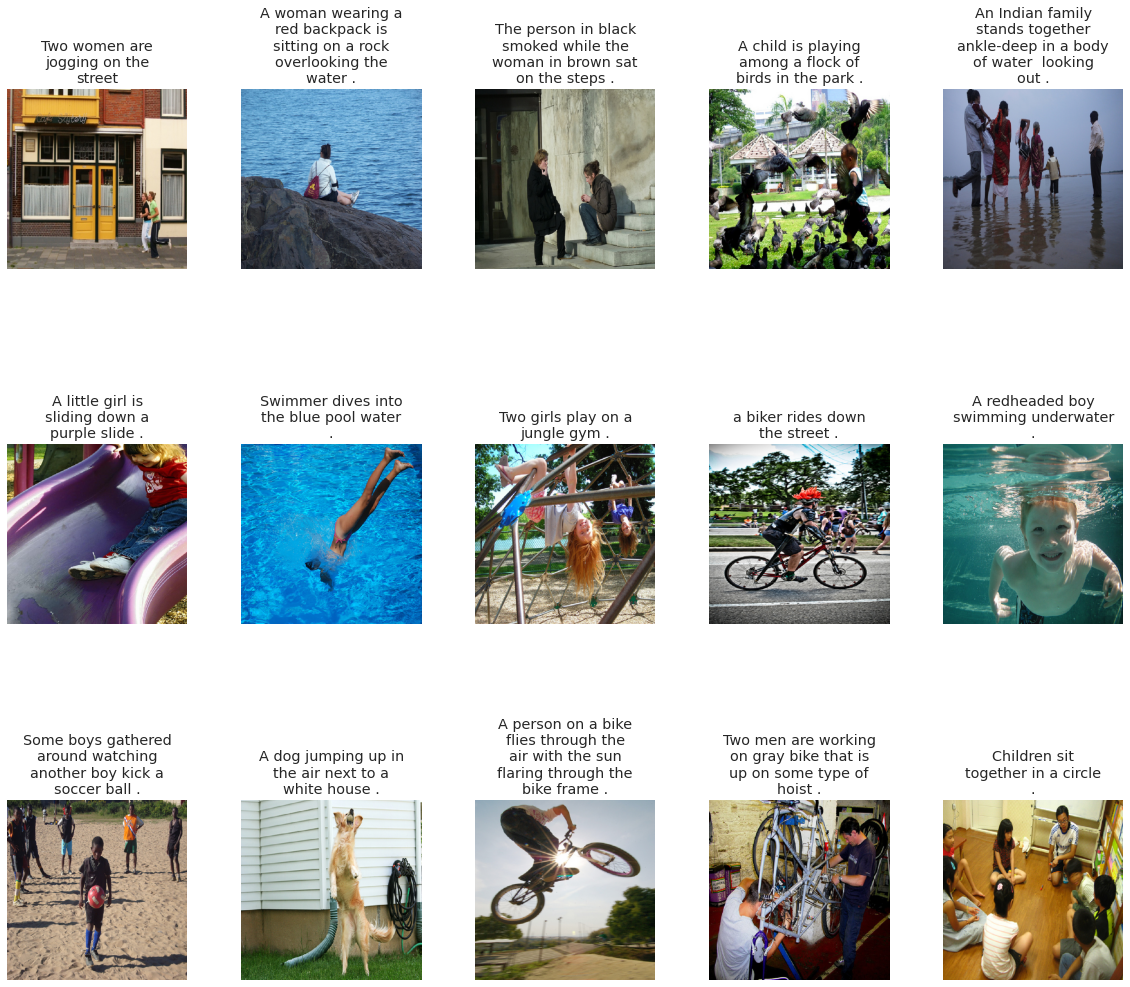

In [7]:
display_images(data.sample(15), img_size = 600)

# **Text Preprocessing Steps**
- Convert sentences into lowercase
- Remove:
        special characters
        numbers
        extra spaces
        single characters
- Add a starting and an ending tag

In [8]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [10]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

## __Tokenization and Encoded Representation__
- The words in a sentence are separated/tokenized and encoded in a one hot representation
- These encodings are then passed to the embeddings layer to generate word embeddings

<img src='https://lena-voita.github.io/resources/lectures/word_emb/lookup_table.gif'>

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 12, 21, 20, 708, 13, 54, 79, 194, 1421, 2]

# **Image Feature Extraction**
- DenseNet 201 Architecture is used to extract the features from the images
- Any other pretrained architecture can also be used for extracting features from these images
- Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920

<img src="https://imgur.com/wWHWbQt.jpg">

In [11]:
# model = DenseNet201()
# fe = Model(inputs=model.input, outputs=model.layers[-2].output)

# img_size = 224
# features = {}
# for image in tqdm(data['image'].unique().tolist()):
#     img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
#     img = img_to_array(img)
#     img = img/255.
#     img = np.expand_dims(img,axis=0)
#     feature = fe.predict(img, verbose=0)
#     features[image] = feature

In [12]:
!pip install -U efficientnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.0 MB/s eta 0:00:00


In [20]:
!pip install -U wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 34.2 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.16
    Uninstalling wandb-0.12.16:
      Successfully uninstalled wandb-0.12.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.9.3 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.16.6 which is incompatible.


In [13]:
!wandb --version

wandb, version 0.12.16


In [14]:
import time 
# Initialize lists to store timestamps
timestamps = {
    'operation': [],
    'start_time': [],
    'end_time': [],
    'duration': []
}
def log_time(operation_name, start_time, end_time):
    """Log the operation times and duration."""
    timestamps['operation'].append(operation_name)
    timestamps['start_time'].append(start_time)
    timestamps['end_time'].append(end_time)
    timestamps['duration'].append(end_time - start_time)

In [15]:
# Logging Time taken to import
import wandb

In [16]:
# Logging Time taken to login
wandb.login()

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [17]:
# Define your configuration
config = {
    "architecture": "EfficientNet",
    "version": "7",
    "image_size": 600
}

# Concatenate config values to form a unique run name
run_name = f"{config['architecture']}-{config['version']}"

# Initialize your W&B run with the dynamically created name
run = wandb.init(project="image-captioning",
           config=config,
           name=run_name)

wandb: Currently logged in as: samyukta-palle (aipi549). Use `wandb login --relogin` to force relogin


In [54]:
from efficientnet.tfkeras import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tqdm import tqdm
import pickle

# Initialize EfficientNet with pretrained weights
base_model = EfficientNetB0(weights='imagenet')  # Change as per version of EfficientNet
# Create a model to retrieve the features from the EfficientNet
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer(index=-2).output)

img_size = 224 # Change as per version of EfficientNet
features = {}

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0
    # Extract features
    feature = feature_extractor.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [33:24<00:00, 15.85it/s] 


In [55]:
# Stored the features, to retrieve later as it takes 2+hrs
# import pickle

# # Serialize the features dictionary to a file
# with open('features.pkl', 'wb') as handle:/
#     pickle.dump(features, handle, protocol=pickle.HIGHEST_PROTOCOL)

# **Data Generation**
- Since Image Caption model training like any other neural network training is a highly resource utillizing process we cannot load the data into the main memory all at once, and hence we need to generate the data in the required format batch wise
- The inputs will be the image embeddings and their corresonding caption text embeddings for the training process
- The text embeddings are passed word by word for the caption generation during inference time

In [56]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y

# **Modelling**
- The image embedding representations are concatenated with the first word of sentence ie. starseq and passed to the LSTM network 
- The LSTM network starts generating words after each input thus forming a sentence at the end

<img src='https://raw.githubusercontent.com/yunjey/pytorch-tutorial/master/tutorials/03-advanced/image_captioning/png/model.png'>

In [64]:
input1 = Input(shape=(1280,)) # Change this as part the version of EfficientNet
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [65]:
from tensorflow.keras.utils import plot_model

## **Model Modification**
- A slight change has been made in the original model architecture to push the performance. The image feature embeddings are added to the output of the LSTMs and then passed on to the fully connected layers
- This slightly improves the performance of the model orignally proposed back in 2014: __Show and Tell: A Neural Image Caption Generator__ (https://arxiv.org/pdf/1411.4555.pdf)

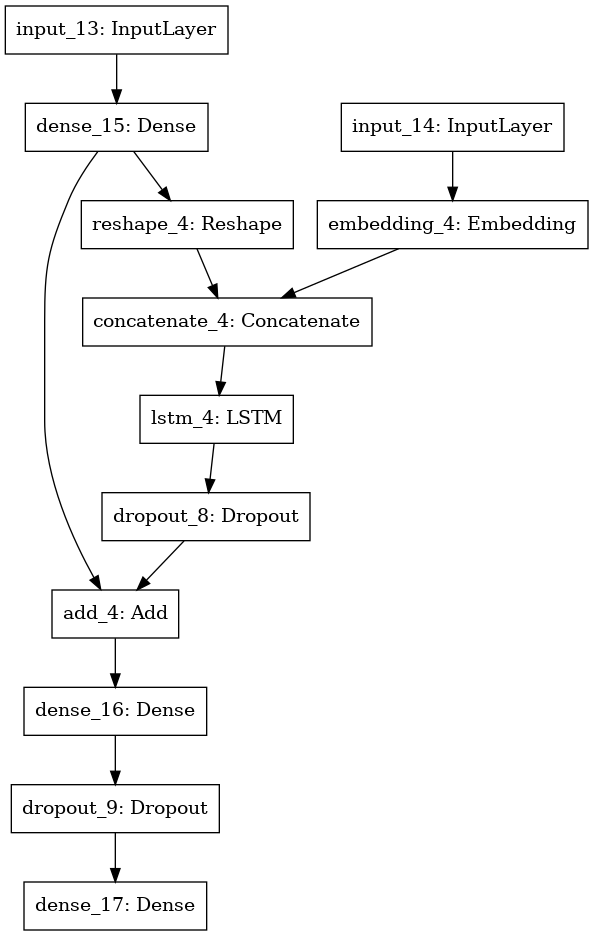

In [66]:
plot_model(caption_model)

In [67]:
caption_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 1280)]       0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 256)          327936      input_13[0][0]                   
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 74)]         0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, 256)       0           dense_15[0][0]                   
____________________________________________________________________________________________

In [68]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [69]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

## **Let's train the Model !**


In [70]:
history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
2110/2110 [==============================] - 1531s 725ms/step - loss: 4.8957 - val_loss: 4.4796

Epoch 00001: val_loss improved from inf to 4.47964, saving model to model.h5
Epoch 2/50
2110/2110 [==============================] - 383s 182ms/step - loss: 4.2115 - val_loss: 4.2414

Epoch 00002: val_loss improved from 4.47964 to 4.24136, saving model to model.h5
Epoch 3/50
2110/2110 [==============================] - 347s 164ms/step - loss: 4.0414 - val_loss: 4.1660

Epoch 00003: val_loss improved from 4.24136 to 4.16603, saving model to model.h5
Epoch 4/50
2110/2110 [==============================] - 382s 181ms/step - loss: 3.9403 - val_loss: 4.1313

Epoch 00004: val_loss improved from 4.16603 to 4.13129, saving model to model.h5
Epoch 5/50
2110/2110 [==============================] - 358s 170ms/step - loss: 3.8712 - val_loss: 4.1138

Epoch 00005: val_loss improved from 4.13129 to 4.11378, saving model to model.h5
Epoch 6/50
2110/2110 [==============================] - 382s 18

In [71]:
caption_model.save('EfficientNetB0.h5')

# **Inference**
- Learning Curve (Loss Curve)
- Assessment of Generated Captions (by checking the relevance of the caption with respect to the image, BLEU Score will not be used in this kernel)

## **Learning Curve**
- The model has clearly overfit, possibly due to less amount of data
- We can tackle this problem in two ways
    1. Train the model on a larger dataset Flickr40k
    2. Attention Models

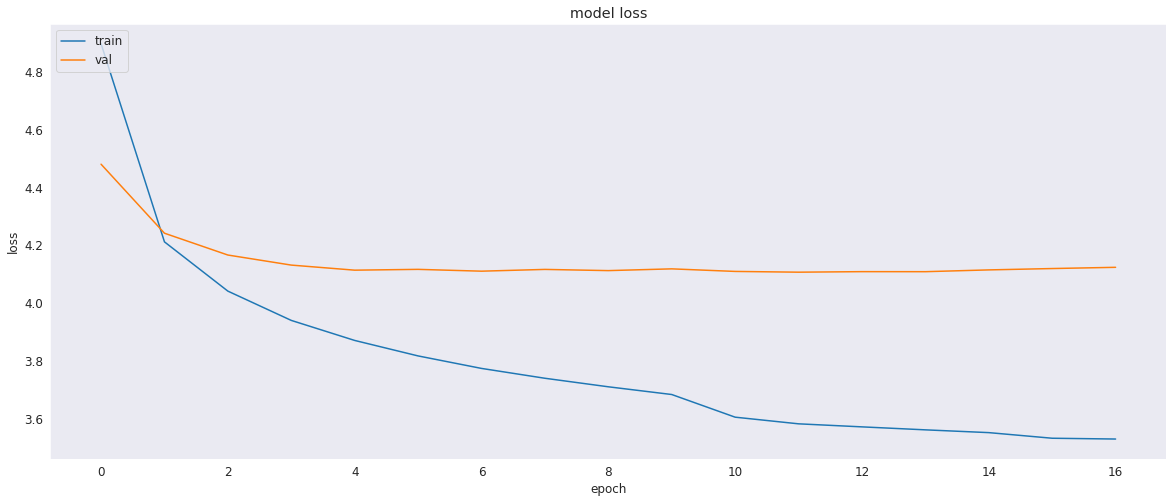

In [72]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## **Caption Generation Utility Functions**
- Utility functions to generate the captions of input images at the inference time.
- Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word

In [73]:
def idx_to_word(integer,tokenizer):
    
    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [74]:
def predict_caption(model, image, tokenizer, max_length, features):
    
    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)
        
        word = idx_to_word(y_pred, tokenizer)
        
        if word is None:
            break
            
        in_text+= " " + word
        
        if word == 'endseq':
            break
            
    return in_text 

## **Taking 15 Random Samples for Caption Prediction**

In [75]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [76]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.
    
    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    samples.loc[index,'caption'] = caption

# **Results**
- As we can clearly see there is some redundant caption generation e.g. Dog running through the water, overusage of blue shirt for any other coloured cloth
- The model performance can be further improved by training on more data and using attention mechanism so that our model can focus on relevant areas during the text generation
- We can also leverage the interprettability of the attention mechanism to understand which areas of the image leads to the generation of which word

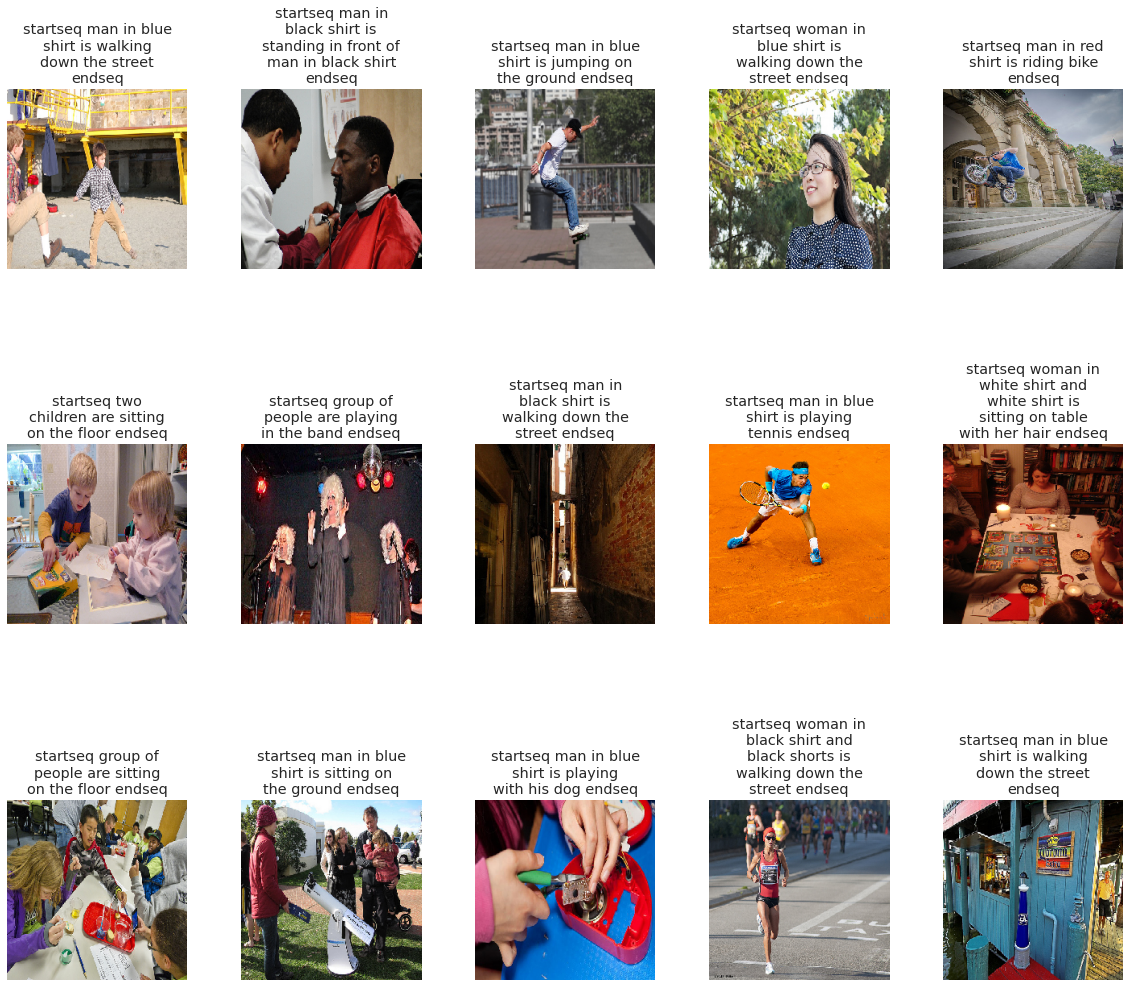

In [77]:
display_images(samples)

<p style='font-size: 18px'><strong>Conclusion: </strong>This may not be the best performing model, but the objective of this kernel is to give a gist of how Image Captioning problems can be approached. In the future work of this kernel <strong>Attention model</strong> training and <strong>BLEU Score</strong> assessment will be performed.</p>